# TCGA - COAD ML

In [2]:
# import libraries

#import python packages 
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
from matplotlib import cm
import random
from matplotlib.lines import Line2D

# PCA Analyis
from sklearn.decomposition import PCA
from IPython.display import Image

# ML 
from sklearn import svm
from sklearn.model_selection import train_test_split,KFold, StratifiedKFold,cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix,roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

# Deep Learning
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from tensorflow import keras
import tensorflow as tf


# Other
%matplotlib inline
import warnings
import os
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Code Functions

In [3]:
# SVM Plot code
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

# SVM Plot code
def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

## Read in data using pandas
Has to be transformed to be used downstream (transposed)

In [4]:
# Load in Data + Trnasform Direction
df=pd.read_csv('log2transformed_and_normalized_gene_expression_data.csv') # load
df=df.transpose()

genes=df.loc['Unnamed: 0'].to_list() # saves all genes as list
df.columns=genes

samples=df.index.to_list()
samples=samples[1:] # removes the "New_Gene" Label

df=df.drop(['Unnamed: 0']).reset_index(drop=True) # remove gene column 
df.index=samples # set index names 

df=df.astype(float) # weird nonsense step thats needed ~sometimes~
df.head() # show results

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,RPS3P6,GSTM2,ST13P11,RANP6,NAP1L1P3,LINC00671,GAPDHP71,COG8,EIF4E2P1,ARHGAP19
TCGA.A6.5665_Tumor1,12.716704,4.833520,10.605669,9.666432,7.583105,7.746044,11.347351,11.594550,10.737055,10.027522,...,0.000000,8.526498,0.000000,0.938912,1.907370,2.481663,0.000000,9.736349,0.000000,8.861221
TCGA.AA.3662_Healthy,12.728542,4.440389,11.323393,9.904937,8.998116,7.706970,10.133867,12.214890,10.983066,10.429991,...,1.409756,7.478087,0.870630,1.409756,2.108974,0.870630,5.488914,9.867042,0.000000,8.487418
TCGA.A6.2684_Healthy,11.812955,5.701675,10.132944,9.498977,7.727813,8.735967,11.234999,11.428503,11.081855,10.148888,...,1.708694,9.612037,0.000000,0.000000,2.138477,4.077288,1.093779,10.020849,0.000000,9.067167
TCGA.A6.5659_Tumor1,14.650295,6.689371,11.628497,9.949801,9.991783,6.240809,9.251160,10.941951,12.294520,11.672900,...,0.000000,7.407009,0.000000,0.000000,4.465318,2.904814,0.000000,10.547631,9.220101,9.383200
TCGA.AA.3511_Healthy,12.432469,5.258396,12.154352,8.850606,8.023267,9.108951,11.370980,11.932527,11.113362,10.297657,...,2.661122,7.883856,0.916508,0.916508,2.185919,1.872878,3.648240,10.005464,0.000000,8.782451


## Using Gene Signature to subset

In [5]:
df_gene_sig=df[['TREML2', 'PTPRN', 'PGLYRP1', 'NOG', 'VIP',\
    'RIMKLB', 'NKAIN4', 'FAM171B', 'ZNF417', 'GLRA2', 'HOXA7', 'FABP6', 'MUSK',\
    'HTR6', 'GRIP2', 'VEGFA', 'AKAP12', 'RHEB', 'PMEPA1','GLTP', 'METTL7A',\
    'CITED2', 'SCARA5', 'CDH3','IL6R', 'PKIB', 'GLP2R', 'EPB41L3', 'NR3C2']]

# Genes not found from gene signature (possible naming issues)
# PADI4, NCKIPSD C5orf53 TREML3 HES5 OR8D2 KLRK1 NCRNA00152 PPAP2A LINC00974

df_gene_sig.head(10)

,TREML2,PTPRN,PGLYRP1,NOG,VIP,RIMKLB,NKAIN4,FAM171B,ZNF417,GLRA2,...,GLTP,METTL7A,CITED2,SCARA5,CDH3,IL6R,PKIB,GLP2R,EPB41L3,NR3C2
TCGA.A6.5665_Tumor1,5.163865,7.045953,0.000000,2.481663,10.630085,8.925217,3.970238,7.505138,7.438055,7.065840,...,12.320419,13.399920,11.965595,11.574300,5.235852,11.012812,12.250186,8.858374,11.055709,11.847057
TCGA.AA.3662_Healthy,4.494414,5.566627,1.409756,2.765371,8.883848,7.230001,4.134978,6.968887,7.122600,7.329957,...,11.079559,10.185072,10.063010,8.463916,12.636749,9.847715,8.060350,5.980358,8.926231,9.717484
TCGA.A6.2684_Healthy,5.130507,8.512218,3.625649,4.259210,11.042827,9.282183,4.077288,8.289738,7.466139,4.495193,...,11.973354,13.375031,12.171185,12.763005,5.176484,11.718993,12.312365,8.498709,12.099533,12.006744
TCGA.A6.5659_Tumor1,1.390835,4.106267,4.992032,3.805130,6.919465,9.289066,1.390835,8.249686,11.917585,10.136038,...,10.236458,10.887394,10.581628,7.474363,10.411630,7.447798,7.262062,3.627154,8.804561,9.454988
TCGA.AA.3511_Healthy,3.017981,6.444461,1.472531,2.850558,8.858903,8.409564,5.002881,8.382962,7.238352,4.877810,...,10.939757,11.527948,10.070021,8.283735,12.064537,9.143323,8.808388,4.787968,9.854585,9.599585
TCGA.AZ.6600_Healthy,3.977576,8.669881,3.160928,4.342888,12.103200,10.055780,4.171764,8.539548,7.494323,6.288557,...,11.844244,12.943214,11.804974,12.725764,5.604791,11.635214,11.966696,8.736652,11.906556,12.022857
TCGA.A6.5667_Tumor,4.634540,5.527445,2.394234,1.829520,7.228764,6.590308,4.584222,7.082368,7.953643,6.442794,...,11.128845,9.393930,12.342774,7.161718,12.650770,8.900208,10.341715,5.059747,8.982645,8.871648
TCGA.A6.2685_Tumor,4.916248,8.422069,3.640337,3.376315,12.151396,9.643311,6.502569,8.667484,7.093277,5.550845,...,11.899099,12.661834,11.813086,10.758106,7.732441,11.215730,11.941403,9.227620,11.393996,11.491781
TCGA.A6.2684_Tumor1,3.206278,1.121457,2.511636,5.901671,4.125926,5.550007,0.000000,7.138572,6.816194,0.000000,...,11.054336,9.616860,11.261972,5.813943,11.950234,7.319355,9.069057,3.800364,7.732133,8.527413
TCGA.AA.3655_Healthy,4.446107,8.773972,4.308667,2.310769,10.452634,10.314724,4.510210,8.280703,7.767462,4.074326,...,11.363796,13.159404,11.826820,12.049773,9.089351,11.307408,9.882385,9.046760,11.920838,11.320875


## Using DESeq2 to subset

In [6]:
df_deseq=pd.read_csv('top_genes.csv') # load
df_deseq.drop(labels=['baseMean','lfcSE','stat','pvalue'],axis=1,inplace=True)
df_deseq.rename(columns={'Unnamed: 0':'genes'},inplace=True)
df_deseq=df_deseq.head(100)
# Filter out by fold change
s0=np.shape(df_deseq)[0]
#df_deseq=df_deseq[np.abs(df_deseq['log2FoldChange'])>3]
s0=s0-np.shape(df_deseq)[0]


# creat new data frame
df_SEQ=df[df_deseq['genes'].to_list()]

# filter out less expressed genes
'''
count=0; # keep track of how many genese removed
thresh=15 # min number of samples needed
for col in df_SEQ.columns.to_list():
    n_zeros=df_SEQ[col].isin([0]).sum()
    
    if n_zeros >= thresh:
        count+=1
        df_SEQ.drop([col],axis=1,inplace=True)

print("Removed %d genes. These genes did not meet 10 sample mininum. Or have log fold >2 \nWe have %d genes left \
"%(count+s0,len(df_SEQ.columns.to_list())))
'''
print(np.shape(df_SEQ))
df_SEQ.head()

(55, 100)


,RNU4-2,SNORA73B,RNU4-1,RNY3,SNORA12,SNORA53,SNORD15B,RNU1-11P,SNORA23,SNORA22,...,SMG1P5,SNORD8,NOC2LP1,SUCNR1,MUC15,SNORA5C,NSA2P3,SPAG17,MAPRE3-AS1,ANKRD36C
TCGA.A6.5665_Tumor1,0.000000,2.700992,1.502923,0.000000,0.000000,1.907370,0.938912,0.000000,0.000000,0.000000,...,4.634833,0.000000,6.216582,5.807996,0.000000,2.700992,1.907370,1.907370,0.000000,4.687128
TCGA.AA.3662_Healthy,1.409756,4.546490,0.000000,0.000000,1.409756,2.108974,2.765371,0.000000,1.409756,1.409756,...,3.214841,0.000000,6.072039,4.946010,0.000000,4.781923,1.409756,3.080001,1.409756,5.591628
TCGA.A6.2684_Healthy,1.093779,2.964573,0.000000,0.000000,1.708694,1.708694,0.000000,0.000000,0.000000,2.138477,...,4.697947,0.000000,6.838351,6.085873,0.000000,3.869070,1.708694,0.000000,0.000000,5.306226
TCGA.A6.5659_Tumor1,15.782877,12.947932,13.669877,8.729353,10.411630,11.636606,10.674774,11.299458,10.778350,11.328872,...,9.542330,7.884073,3.963542,6.359577,3.424092,8.295101,10.455628,7.513317,6.919465,11.969283
TCGA.AA.3511_Healthy,1.872878,3.303842,0.000000,0.000000,0.000000,1.872878,2.442999,0.000000,0.000000,0.916508,...,5.117968,0.000000,3.648240,6.289394,0.916508,4.228883,1.872878,1.872878,0.916508,5.663980


### Creating Heatmap

# Load in Data + Trnasform Direction
df0=pd.read_csv('test.csv') # load
df0=df0.transpose()

genes=df0.loc['Unnamed: 0'].to_list() # saves all genes as list
df0.columns=genes

samples=df0.index.to_list()
samples=samples[1:] # removes the "New_Gene" Label

df0=df0.drop(['Unnamed: 0']).reset_index(drop=True) # remove gene column 
df0.index=samples # set index names 

df0=df0.astype(float) # weird nonsense step thats needed ~sometimes~
df0.head() # show results

df_SEQ.head()

fig =plt.figure(figsize=(9.5,6.5))

df_deseq=pd.read_csv('top_genes.csv') # load
df_deseq.drop(labels=['baseMean','lfcSE','stat','pvalue'],axis=1,inplace=True)
df_deseq.rename(columns={'Unnamed: 0':'genes'},inplace=True)
df_deseq=df_deseq.head(100)
# creat new data frame
df_SEQ=df0[df_deseq['genes'].to_list()]
df2=df_SEQ.copy()
for col in df2:
    df2[col]=df2[col].apply(lambda x : (x-df2[col].min())/(df2[col].max()-df2[col].min()))
    
df2=df2.fillna(0)
df2=df2.transpose()
sns.heatmap(df2)

## Titles
plt.title('Top 100 Differentialy Expressed Genes Using DESeq2', fontsize=16, fontweight='black', color = '#333F4B')

## Getting Random genes

In [7]:
num_genes=100
genes=df.columns.to_list()
# generate random genes
random.seed(32)
n = random.sample(range(0, len(genes)), num_genes)
rand_genes=[genes[i] for i in n]
# subset dataset
rand_df=df[rand_genes].copy()

## Extract Tissue sample from columns (healthy or tumor)
and then stick that into a panda series (single column dataframe). This is out "Y" while the df1 which contains all the genes is our "X".

We can do this since the "X" and "y" align via index. 

E.g 3rd row in df1 (TCGA.A6.2684_Healthy) has target  of "healthy" in Y!

In [8]:
# Create Target vector
target=[]
sample_names=[]

# loop through and extract tumor + healthy
for i in samples:
    
    temp=i.split('_')[1] # Split string using "_"
    #remove numbers at end (if they have it)
    if temp[-1].isnumeric():
        temp=temp[:-1]
    
    target.append(temp)# save tissues type to list (in order)

        
# Convert to Panda Series
target=pd.Series(target,name='Tissue')

In [9]:
# Convert to binary tumor=(1) + healthy=(0)
target_binary=[]
for i in target:
    if i=='Healthy':
        target_binary.append(0)
    else:
        target_binary.append(1)
        
# Convert to Panda Series
target_binary=pd.Series(target_binary)

In [10]:
# create colors labels for PCA
colors=[]
for i in target_binary:
    if i ==1:
        colors.append('red')
    else:
        colors.append('blue')
    

# Visualize Data

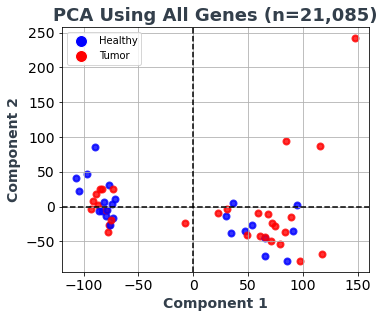

In [11]:
# Generate Colors + numbers
fig =plt.figure(figsize=(5.5,4.5))
num_list=range(0,54)

# PCA 
pca = PCA(n_components=2)
X_r = pca.fit(df).transform(df)
# Plot

for color, i, target_name in zip(colors, num_list, samples):
    plt.scatter(X_r[i,0], X_r[i,1], color=color, alpha=.8, lw=2,
                label=target_name)
    

plt.title('PCA Using All Genes (n=21,085)', fontsize=18, fontweight='black', color = '#333F4B')
plt.axvline(x=0,linestyle='--',c='k')
plt.axhline(y=0,linestyle='--',c='k')
plt.tick_params(axis='y', which='major', labelsize=14)
plt.tick_params(axis='x', which='major', labelsize=14)
plt.grid(True)
plt.xlabel('Component 1', fontsize=14, fontweight='black', color = '#333F4B')
plt.ylabel('Component 2', fontsize=14, fontweight='black', color = '#333F4B')

# Adding legend

legend_elements = [ Line2D([0], [0], marker='o', color='w', label='Healthy', markerfacecolor='b', markersize=12),\
                   Line2D([0], [0], marker='o', color='w', label='Tumor', markerfacecolor='r', markersize=12)]
plt.legend(handles=legend_elements,loc='best')


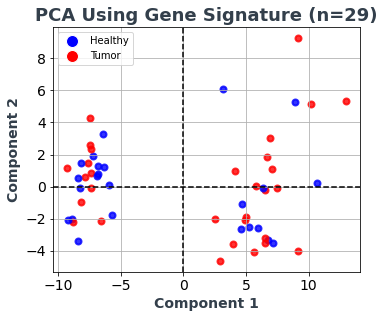

In [12]:
# Generate Colors + numbers
num_list=range(0,54)
fig =plt.figure(figsize=(5.5,4.5))
# PCA 
pca = PCA(n_components=2)
X_r = pca.fit(df_gene_sig).transform(df_gene_sig)
# Plot

for color, i, target_name in zip(colors, num_list, samples):
    plt.scatter(X_r[i,0], X_r[i,1], color=color, alpha=.8, lw=2,
                label=target_name)
    
    
plt.title('PCA Using Gene Signature (n=29)', fontsize=18, fontweight='black', color = '#333F4B')
plt.axvline(x=0,linestyle='--',c='k')
plt.axhline(y=0,linestyle='--',c='k')
plt.tick_params(axis='y', which='major', labelsize=14)
plt.tick_params(axis='x', which='major', labelsize=14)
plt.grid(True)
plt.xlabel('Component 1', fontsize=14, fontweight='black', color = '#333F4B')
plt.ylabel('Component 2', fontsize=14, fontweight='black', color = '#333F4B')

# Adding legend

legend_elements = [ Line2D([0], [0], marker='o', color='w', label='Healthy', markerfacecolor='b', markersize=12),\
                   Line2D([0], [0], marker='o', color='w', label='Tumor', markerfacecolor='r', markersize=12)]
plt.legend(handles=legend_elements,loc='best')

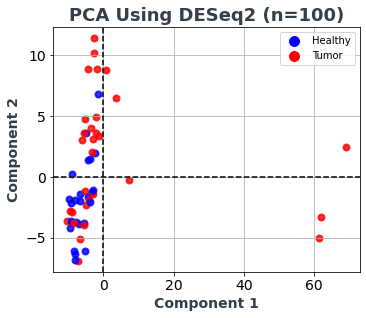

In [13]:
# Generate Colors + numbers
num_list=range(0,54)
fig =plt.figure(figsize=(5.5,4.5))
# PCA 
pca = PCA(n_components=2)
X_r = pca.fit(df_SEQ).transform(df_SEQ)
# Plot

for color, i, target_name in zip(colors, num_list, samples):
    plt.scatter(X_r[i,0], X_r[i,1], color=color, alpha=.8, lw=2,
                label=target_name)
    
    
plt.title('PCA Using DESeq2 (n=100)', fontsize=18, fontweight='black', color = '#333F4B')
plt.axvline(x=0,linestyle='--',c='k')
plt.axhline(y=0,linestyle='--',c='k')
plt.tick_params(axis='y', which='major', labelsize=14)
plt.tick_params(axis='x', which='major', labelsize=14)
plt.grid(True)
plt.xlabel('Component 1', fontsize=14, fontweight='black', color = '#333F4B')
plt.ylabel('Component 2', fontsize=14, fontweight='black', color = '#333F4B')

# Adding legend

legend_elements = [ Line2D([0], [0], marker='o', color='w', label='Healthy', markerfacecolor='b', markersize=12),\
                   Line2D([0], [0], marker='o', color='w', label='Tumor', markerfacecolor='r', markersize=12)]
plt.legend(handles=legend_elements,loc='best')


## Split Data - K Folds Cross Validation

# Machine Learning

## SVM

### Create Model

In [14]:
#GET PCA of Gene Sig
pca = PCA(n_components=2)
Xreduced = pca.fit_transform(df_gene_sig)
#pca_cov = pd.DataFrame({"Gene": genes,"PC1_Covariance":abs(pca.components_[0]),"PC2_Covariance":abs(pca.components_[1]) })

# Split Data
x_train, x_test, y_train, y_test = train_test_split(Xreduced, target_binary, test_size=15,shuffle=True, random_state=12)
clf_gs = svm.NuSVC(gamma='auto')

In [15]:
np.shape(Xreduced)

(55, 2)

### Train Model - Gene Signature - SVM

In [16]:
# Fit model
clf_gs.fit(x_train, y_train)

# Get results of TRAIN data
results = clf_gs.predict(x_train)

# Generate ROC Curve
fpr_train_gs_svm, tpr_train_gs_svm, thresholds_rf = roc_curve(y_train, results)

# Calculate AUC (Area under the ROC Curve )
train_auc_gs_svm = round(auc(fpr_train_gs_svm, tpr_train_gs_svm),2)
print(train_auc_gs_svm)

0.87


### Test Model - Gene Signature - SVM

In [17]:
# run it foward - to predict using TEST
results=clf_gs.predict(x_test)

# Generate ROC Curve 
fpr_test_gs_svm, tpr_test_gs_svm, thresholds_rf = roc_curve(y_test, results)

# Calculate AUC (Area under the ROC Curve )
test_auc_gs_svm = round(auc(fpr_test_gs_svm, tpr_test_gs_svm),2)

# show results FOR TEST + Overall Train
print('AUC: %.4f'%(test_auc_gs_svm))

AUC: 0.7500


### Decison Boundary

In [ ]:
# Plot 
fig, ax = plt.subplots()

# Set-up grid for plotting.
X0, X1 = Xreduced[:, 0], Xreduced[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf_gs, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=target_binary, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

# Plot Labels
ax.set_ylabel('PC2')
ax.set_xlabel('PC1')

# Plot Sizing
ax.set_xticks(())
ax.set_yticks(())
ax.set_title('Decison surface using the PCA transformed/projected features - All')
ax.legend()
plt.show()

### Create Model - DESeq2 - SVM

In [149]:
#GET PCA of Gene Sig
pca = PCA(n_components=2)
Xreduced = pca.fit_transform(df_SEQ)
#pca_cov = pd.DataFrame({"Gene": genes,"PC1_Covariance":abs(pca.components_[0]),"PC2_Covariance":abs(pca.components_[1]) })

# Split Data
x_train, x_test, y_train, y_test = train_test_split(Xreduced, target_binary, test_size=15,shuffle=True, random_state=12)
clf_seq = svm.NuSVC(gamma='auto')


### Train Model - DESeq2 - SVM

In [150]:
# Fit model
clf_seq.fit(x_train, y_train)

# Get results of TRAIN data
results = clf_seq.predict(x_train)

# Generate ROC Curve
fpr_train_seq_svm, tpr_train_seq_svm, thresholds_rf = roc_curve(y_train, results)

# Calculate AUC (Area under the ROC Curve )
train_auc_seq_svm = round(auc(fpr_train_seq_svm, tpr_train_seq_svm),2)
print(train_auc_seq_svm)

0.9


### Test Model - DESeq2 - SVM

In [151]:
# run it foward - to predict using TEST
results=clf_seq.predict(x_test)

# Generate ROC Curve 
fpr_test_seq_svm, tpr_test_seq_svm, thresholds_rf = roc_curve(y_test, results)

# Calculate AUC (Area under the ROC Curve )
test_auc_seq_svm = auc(fpr_test_seq_svm, tpr_test_seq_svm)

# show results FOR TEST + Overall Train
print('AUC: %.4f'%(test_auc_seq_svm))

AUC: 0.6500


### Plotting Decision Boundary

No handles with labels found to put in legend.


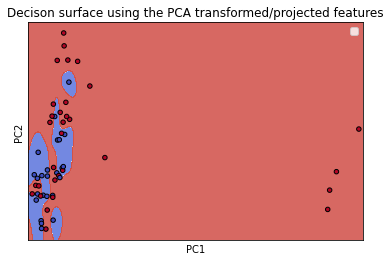

In [21]:
# Plot 
fig, ax = plt.subplots()

# Set-up grid for plotting.
X0, X1 = Xreduced[:, 0], Xreduced[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf_seq, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=target_binary, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

# Plot Labels
ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
title = ('Decision surface of linear SVC ')

# Plot Sizing
ax.set_xticks(())
ax.set_yticks(())
ax.set_title('Decison surface using the PCA transformed/projected features')
ax.legend()
plt.show()

### Create Model - Random Genes - SVM

In [130]:
#GET PCA of Gene Sig
pca = PCA(n_components=2)
Xreduced = pca.fit_transform(rand_df)
#pca_cov = pd.DataFrame({"Gene": genes,"PC1_Covariance":abs(pca.components_[0]),"PC2_Covariance":abs(pca.components_[1]) })

# Split Data
x_train, x_test, y_train, y_test = train_test_split(Xreduced, target_binary, test_size=15,shuffle=True, random_state=12)
clf_rand = svm.NuSVC(gamma='auto')

### Train Model - Random Genes - SVM

In [131]:
# Fit model
clf_rand.fit(x_train, y_train)

# Get results of TRAIN data
results = clf_rand.predict(x_train)

# Generate ROC Curve
fpr_train_rand_svm, tpr_train_rand_svm, thresholds_rf = roc_curve(y_train, results)

# Calculate AUC (Area under the ROC Curve )
train_auc_rand_svm = round(auc(fpr_train_rand_svm, tpr_train_rand_svm),2)
print(train_auc_rand_svm)

0.98


### Test Model - Random Genes - SVM

In [132]:
# run it foward - to predict using TEST
results=clf_rand.predict(x_test)

# Generate ROC Curve 
fpr_test_rand_svm, tpr_test_rand_svm, thresholds_rf = roc_curve(y_test, results)

# Calculate AUC (Area under the ROC Curve )
test_auc_rand_svm = round(auc(fpr_test_rand_svm, tpr_test_rand_svm),2)

# show results FOR TEST + Overall Train
print('AUC: %.4f'%(test_auc_rand_svm))

AUC: 0.6000


### Decision Boundary

No handles with labels found to put in legend.


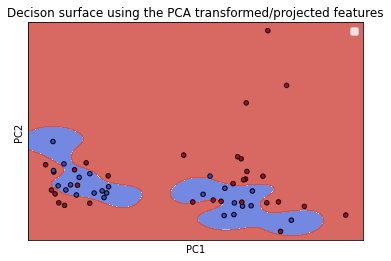

In [25]:
# Plot 
fig, ax = plt.subplots()

# Set-up grid for plotting.
X0, X1 = Xreduced[:, 0], Xreduced[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf_rand, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=target_binary, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

# Plot Labels
ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
title = ('Decision surface of linear SVC ')

# Plot Sizing
ax.set_xticks(())
ax.set_yticks(())
ax.set_title('Decison surface using the PCA transformed/projected features')
ax.legend()
plt.show()

### Combined Plot - SVM

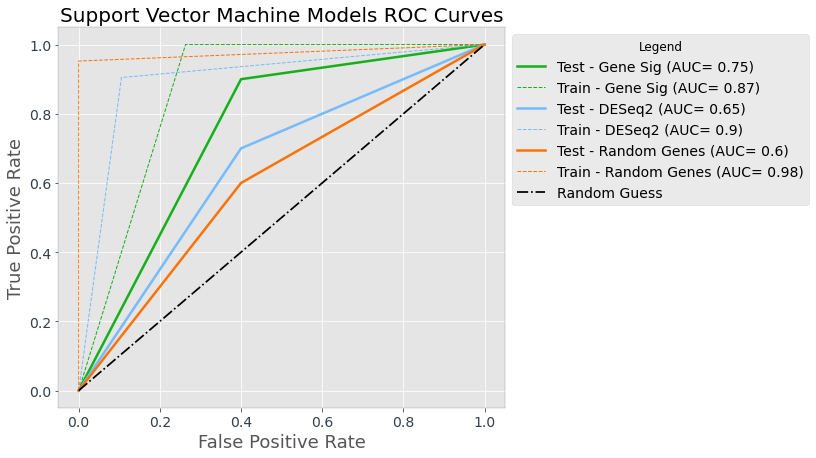

In [180]:
# Combine into single plot
fig =plt.figure(figsize=(8,7))

# Plot Gene Sig
test_label='Test - Gene Sig (AUC= '+str(test_auc_gs_svm)+')'
plt.plot(fpr_test_gs_svm, tpr_test_gs_svm,'b', label=test_label,linewidth=2.5,color='xkcd:green')
train_label='Train - Gene Sig (AUC= '+str(train_auc_gs_svm)+')'
plt.plot(fpr_train_gs_svm, tpr_train_gs_svm, '--b',label=train_label,linewidth=1,color='xkcd:green')
#plt.fill_between(base_fpr, tprs_lower_gs, tprs_upper_gs, color='grey', alpha=0.3,label='STD 1')


# Plot DESEQ
test_label='Test - DESeq2 (AUC= '+str(round(test_auc_seq_svm,2))+')'
plt.plot(fpr_test_seq_svm, tpr_test_seq_svm,'r', label=test_label,linewidth=2.5,color='xkcd:sky blue')
train_label='Train - DESeq2 (AUC= '+str(train_auc_seq_svm)+')'
plt.plot(fpr_train_seq_svm, tpr_train_seq_svm, '--r',label=train_label,linewidth=1,color='xkcd:sky blue')
#plt.fill_between(base_fpr, tprs_lower_deseq, tprs_upper_deseq, color='grey', alpha=0.3,label='STD 1')

# Plot Random
test_label='Test - Random Genes (AUC= '+str(round(test_auc_rand_svm,2))+')'
plt.plot(fpr_test_rand_svm, tpr_test_rand_svm,'g', label=test_label,linewidth=2.5,color='xkcd:orange')
train_label='Train - Random Genes (AUC= '+str(train_auc_rand_svm)+')'
plt.plot(fpr_train_rand_svm, tpr_train_rand_svm, '--g',label=train_label,linewidth=1,color='xkcd:orange')
#plt.fill_between(base_fpr, tprs_lower_rand, tprs_upper_rand, color='grey', alpha=0.3,label='STD 1')


# Labels and Plot settings
plt.plot([0, 1], [0, 1],'-.k',label='Random Guess',linewidth=1.75)
plt.ylabel('True Positive Rate',fontsize=18)
plt.xlabel('False Positive Rate',fontsize=18)
plt.title('Support Vector Machine Models ROC Curves',fontsize=20)
plt.legend(title='Legend', bbox_to_anchor=(1, 1), loc='upper left',fontsize=14)
plt.rcParams['legend.title_fontsize'] = 'large'
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

## Random Forest

### Create Model

In [27]:
x_train, x_test, y_train, y_test = train_test_split(df_gene_sig, target_binary, test_size=15,shuffle=True, random_state=12)

# Initialize random forest mode
rfc_gs = RandomForestClassifier()

### Train Model - Gene Signature - RF

In [28]:
# Fit model
rfc_gs.fit(x_train, y_train)

# Get results of TRAIN data
results = rfc_gs.predict(x_train)

# Generate ROC Curve
fpr_train_gs_rf, tpr_train_gs_rf, thresholds_rf = roc_curve(y_train, results)

# Calculate AUC (Area under the ROC Curve )
auc_train_gs_rf = auc(fpr_train_gs_rf, tpr_train_gs_rf)
print(auc_train_gs_rf)

1.0


### Test Model - Gene Signature - RF

In [29]:
# run it foward - to predict using TEST
results=rfc_gs.predict(x_test)

# Generate ROC Curve 
fpr_test_gs_rf, tpr_test_gs_rf, thresholds_rf = roc_curve(y_test, results)

# Calculate AUC (Area under the ROC Curve )
auc_test_gs_rf = auc(fpr_test_gs_rf, tpr_test_gs_rf)

# show results FOR TEST + Overall Train
print('AUC: %.4f'%(auc_test_gs_rf))

AUC: 0.7000


### Create Model

In [153]:
x_train, x_test, y_train, y_test = train_test_split(df_SEQ, target_binary, test_size=15,shuffle=True, random_state=12)

# Initialize random forest mode
rfc_seq = RandomForestClassifier(min_samples_split=5)

### Train Model - DESeq2 - RF

In [163]:
# Fit model
rfc_seq.fit(x_train, y_train)

# Get results of TRAIN data
results = rfc_seq.predict(x_train)

# Generate ROC Curve
fpr_train_seq_rf, tpr_train_seq_rf, thresholds_rf = roc_curve(y_train, results)

# Calculate AUC (Area under the ROC Curve )
auc_train_seq_rf = auc(fpr_train_seq_rf, tpr_train_seq_rf)
print(auc_train_seq_rf)

1.0


### Test Model - DESeq2 - RF

In [164]:
# run it foward - to predict using TEST
results=rfc_seq.predict(x_test)

# Generate ROC Curve 
fpr_test_seq_rf, tpr_test_seq_rf, thresholds_rf = roc_curve(y_test, results)

# Calculate AUC (Area under the ROC Curve )
auc_test_seq_rf = auc(fpr_test_seq_rf, tpr_test_seq_rf)

# show results FOR TEST + Overall Train
print('AUC: %.4f'%(auc_test_seq_rf))

AUC: 0.8000


### Create Model - Random - RF

In [98]:
x_train, x_test, y_train, y_test = train_test_split(rand_df, target_binary, test_size=15,shuffle=True, random_state=12)

# Initialize random forest mode
rfc_rand = RandomForestClassifier()

### Train Model - Random Genes - RF

In [112]:
# Fit model
rfc_rand.fit(x_train, y_train)

# Get results of TRAIN data
results = rfc_rand.predict(x_train)

# Generate ROC Curve
fpr_train_rand_rf, tpr_train_rand_rf, thresholds_rf = roc_curve(y_train, results)

# Calculate AUC (Area under the ROC Curve )
auc_train_rand_rf = auc(fpr_train_rand_rf, tpr_train_rand_rf)
print(auc_train_rand_rf)


1.0


### Test Model - Random Genes - RF

In [113]:
# run it foward - to predict using TEST

results=rfc_rand.predict(x_test)

# Generate ROC Curve 
fpr_test_rand_rf, tpr_test_rand_rf, thresholds_rf = roc_curve(y_test, results)

# Calculate AUC (Area under the ROC Curve )
auc_test_rand_rf = auc(fpr_test_rand_rf, tpr_test_rand_rf)

# show results FOR TEST + Overall Train
print('AUC: %.4f'%(auc_test_rand_rf))

AUC: 0.5500


### Combined Plot - Random Forest

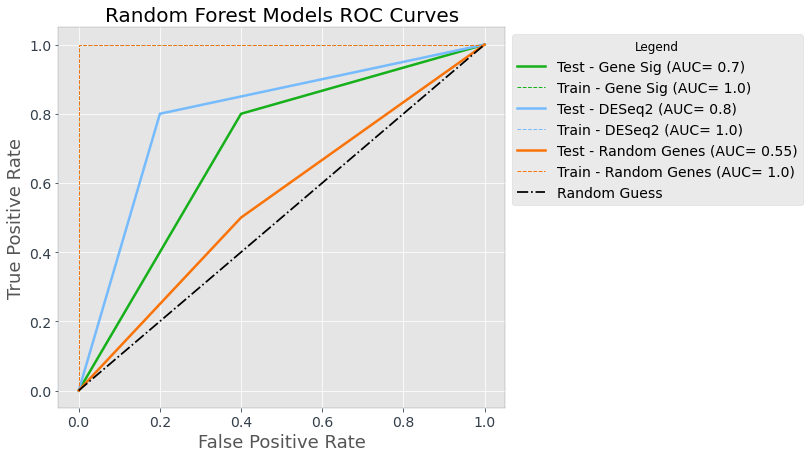

In [179]:
# Combine into single plot
fig =plt.figure(figsize=(8,7))

# Plot Gene Sig
test_label='Test - Gene Sig (AUC= '+str(round(auc_test_gs_rf,2))+')'
plt.plot(fpr_test_gs_rf, tpr_test_gs_rf,'b', label=test_label,linewidth=2.5,color='xkcd:green')
train_label='Train - Gene Sig (AUC= '+str(auc_train_gs_rf)+')'
plt.plot(fpr_train_gs_rf, tpr_train_gs_rf, '--b',label=train_label,linewidth=1,color='xkcd:green')
#plt.fill_between(base_fpr, tprs_lower_gs, tprs_upper_gs, color='grey', alpha=0.3,label='STD 1')


# Plot DESEQ
test_label='Test - DESeq2 (AUC= '+str(round(auc_test_seq_rf,2))+')'
plt.plot(fpr_test_seq_rf, tpr_test_seq_rf,'r', label=test_label,linewidth=2.5,color='xkcd:sky blue')
train_label='Train - DESeq2 (AUC= '+str(auc_train_seq_rf)+')'
plt.plot(fpr_train_seq_rf, tpr_train_seq_rf, '--r',label=train_label,linewidth=1,color='xkcd:sky blue')
#plt.fill_between(base_fpr, tprs_lower_deseq, tprs_upper_deseq, color='grey', alpha=0.3,label='STD 1')

# Plot Random
test_label='Test - Random Genes (AUC= '+str(round(auc_test_rand_rf,2))+')'
plt.plot(fpr_test_rand_rf, tpr_test_rand_rf,'g', label=test_label,linewidth=2.5,color='xkcd:orange')
train_label='Train - Random Genes (AUC= '+str(auc_train_rand_rf)+')'
plt.plot(fpr_train_rand_rf, tpr_train_rand_rf, '--g',label=train_label,linewidth=1,color='xkcd:orange')
#plt.fill_between(base_fpr, tprs_lower_rand, tprs_upper_rand, color='grey', alpha=0.3,label='STD 1')


# Labels and Plot settings
plt.plot([0, 1], [0, 1],'-.k',label='Random Guess',linewidth=1.75)
plt.ylabel('True Positive Rate',fontsize=18)
plt.xlabel('False Positive Rate',fontsize=18)
plt.title('Random Forest Models ROC Curves',fontsize=20)
plt.legend(title='Legend', bbox_to_anchor=(1, 1), loc='upper left',fontsize=14)
plt.rcParams['legend.title_fontsize'] = 'large'
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

## Deep Learning

#### Create  Model

In [72]:
# Creating Model

# create model for small gene set
def baseline_model():
  # create model
    model = Sequential()
    model.add(Dense(16, input_dim=29, activation='relu'))
    #model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='Nadam', metrics=['accuracy'])
    return model

### Train Model - Gene Signature - DL

In [73]:
# Re-split Data - this doesn't chnage rows but since we're using more genes we need to re-split to capture

# Split Into Training and Test Data
x_train, x_test, y_train, y_test = train_test_split(df_gene_sig, target_binary, test_size=15,shuffle=True, random_state=12)
kf = KFold(n_splits = 4)                      
skf = StratifiedKFold(n_splits = 4, random_state = 12, shuffle = True) # Generates indicies


In [76]:
# Train

# Intialize Model
estimator = KerasClassifier(build_fn=baseline_model, epochs=125, batch_size=2, verbose=0)

# Intialize counter + Total Accuarcy
c=1
tprs_gs = []
aucs_gs = []
# For interplotting to smooth curve
base_fpr = np.linspace(0, 1, 201)

# Loop through 4 - K folds and train model 
for train_index, test_index in skf.split(x_train, y_train):
    print('\nFold Number: %d'%(c))
    
    # Get nth fold data (from before where we print out index)
    X=x_train.iloc[train_index]
    Y=y_train.iloc[train_index]
    
    # Train model using fold data
    estimator.fit(X, Y)
    
    # Get results of TRAIN data
    results=estimator.predict(x_train)
    
    # Create Confusion matrix using prediction + truth 
    cm=confusion_matrix(y_train, results)
    
    # Generate ROC Curve
    fpr_kera, tpr_kera, thresholds_rf = roc_curve(y_train, results)
    
    # Calculate AUC (Area under the ROC Curve )
    auc_k = auc(fpr_kera, tpr_kera)
    
    # Generate label for this fold's line in plot
    lab='Fold#:'+str(c)
    # Plot ROC line for this fild
    #plt.plot(fpr_kera, tpr_kera, label=lab)
    
    # save values
    acc_temp=round((cm[1,1]+cm[0,0])/45,4)
    tpr = np.interp(base_fpr, fpr_kera, tpr_kera)
    tpr[0] = 0.0
    tprs_gs.append(tpr)
    aucs_gs.append(auc_k)
    
    # Uncomment to see results per fold
    print('AUC: %.4f'%(auc_k))

    
    # Iterate fold num
    c+=1


Fold Number: 1
AUC: 0.6228

Fold Number: 2
AUC: 0.7995

Fold Number: 3
AUC: 0.7444

Fold Number: 4
AUC: 0.7469


### Test Model - Gene Signature -DL

In [77]:
# Test Set - now that we've trained, we can now use test set to

# run it foward - to predict using TEST
results=estimator.predict(x_test)

# Create Confusion matrix using prediction + truth 
cm=confusion_matrix(y_test, results)

# Generate ROC Curve 
fpr_gs, tpr_gs, thresholds_rf = roc_curve(y_test, results)

# Calculate AUC (Area under the ROC Curve )
test_auc_gs = auc(fpr_gs, tpr_gs)


# show results FOR TEST + Overall Train
print('AUC: %.4f'%(test_auc_gs))



AUC: 0.7000


### Train Model with DESEQ2 genes -DL

In [92]:
# Creating Model

# create model for small gene set
def baseline_model():
  # create model
    model = Sequential()
    model.add(Dense(32, input_dim=100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='Nadam', metrics=['accuracy'])
    return model

In [93]:
# Re-split Data - this doesn't chnage rows but since we're using more genes we need to re-split to capture

# Split Into Training and Test Data
x_train, x_test, y_train, y_test = train_test_split(df_SEQ, target_binary, test_size=15,shuffle=True, random_state=12)
kf = KFold(n_splits = 4)                      
skf = StratifiedKFold(n_splits = 4, random_state = 12, shuffle = True) # Generates indicies


In [96]:
# Train

# Intialize Model
estimator = KerasClassifier(build_fn=baseline_model, epochs=125, batch_size=2, verbose=0)

# Intialize counter + Total Accuarcy
c=1
tprs_deseq = []
aucs_deseq = []
# For interplotting to smooth curve
base_fpr = np.linspace(0, 1, 201)

# Loop through 4 - K folds and train model 
for train_index, test_index in skf.split(x_train, y_train):
    print('\nFold Number: %d'%(c))
    
    # Get nth fold data (from before where we print out index)
    X=x_train.iloc[train_index]
    Y=y_train.iloc[train_index]
    
    # Train model using fold data
    estimator.fit(X, Y)
    # Get results of TRAIN data
    results=estimator.predict(x_train)
    
    # Create Confusion matrix using prediction + truth 
    cm=confusion_matrix(y_train, results)
    
    # Generate ROC Curve
    fpr_kera, tpr_kera, thresholds_rf = roc_curve(y_train, results)
    
    # Calculate AUC (Area under the ROC Curve )
    auc_k = auc(fpr_kera, tpr_kera)
    
    # Generate label for this fold's line in plot
    lab='Fold#:'+str(c)
    # Plot ROC line for this fild
    #plt.plot(fpr_kera, tpr_kera, label=lab)
    
    # save values
    acc_temp=round((cm[1,1]+cm[0,0])/45,4)
    tpr = np.interp(base_fpr, fpr_kera, tpr_kera)
    tpr[0] = 0.0
    tprs_deseq.append(tpr)
    aucs_deseq.append(auc_k)
    
    # Uncomment to see results per fold
    print('AUC: %.4f'%(auc_k))

    
    # Iterate fold num
    c+=1


Fold Number: 1
AUC: 0.9499

Fold Number: 2
AUC: 1.0000

Fold Number: 3
AUC: 0.9211

Fold Number: 4
AUC: 0.9524


### Test Model with Deseq2 genes -DL

In [97]:
# Test Set - now that we've trained, we can now use test set to

# run it foward - to predict using TEST
results=estimator.predict(x_test)

# Create Confusion matrix using prediction + truth 
cm=confusion_matrix(y_test, results)

# Generate ROC Curve 
fpr_deseq, tpr_deseq, thresholds_rf = roc_curve(y_test, results)

# Calculate AUC (Area under the ROC Curve )
test_auc_deseq = auc(fpr_deseq, tpr_deseq)

# label for plot
lab='Test'
#plt.plot(fpr_kera, tpr_kera, label=lab)

# Uncomment to print results
print('AUC: %.4f'%(test_auc_deseq))


AUC: 0.8500


### Train Model with random genes - DL

In [79]:
# Creating Model

# create model for small gene set
def baseline_model():
  # create model
    model = Sequential()
    model.add(Dense(64, input_dim=100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='Nadam', metrics=['accuracy'])
    return model

In [80]:
# Re-split Data - this doesn't chnage rows but since we're using more genes we need to re-split to capture

# Split Into Training and Test Data
x_train, x_test, y_train, y_test = train_test_split(rand_df, target_binary, test_size=15,shuffle=True, random_state=12)
kf = KFold(n_splits = 4)                      
skf = StratifiedKFold(n_splits = 4, random_state = 12, shuffle = True) # Generates indicies


In [90]:
# Train

# Intialize Model
estimator = KerasClassifier(build_fn=baseline_model, epochs=125, batch_size=2, verbose=0)

# Intialize counter + Total Accuarcy
c=1
tprs_rand = []
aucs_rand = []
# For interplotting to smooth curve
base_fpr = np.linspace(0, 1, 201)

# Loop through 4 - K folds and train model 
for train_index, test_index in skf.split(x_train, y_train):
    print('\nFold Number: %d'%(c))
    
    # Get nth fold data (from before where we print out index)
    X=x_train.iloc[train_index]
    Y=y_train.iloc[train_index]
    
    # Train model using fold data
    estimator.fit(X, Y)
    # Get results of TRAIN data
    results=estimator.predict(x_train)
    
    # Create Confusion matrix using prediction + truth 
    cm=confusion_matrix(y_train, results)
    
    # Generate ROC Curve
    fpr_kera, tpr_kera, thresholds_rf = roc_curve(y_train, results)
    
    # Calculate AUC (Area under the ROC Curve )
    auc_k = auc(fpr_kera, tpr_kera)
    
    # Generate label for this fold's line in plot
    lab='Fold#:'+str(c)
    # Plot ROC line for this fild
    #plt.plot(fpr_kera, tpr_kera, label=lab)
    
    # save values
    acc_temp=round((cm[1,1]+cm[0,0])/45,4)
    tpr = np.interp(base_fpr, fpr_kera, tpr_kera)
    tpr[0] = 0.0
    tprs_rand.append(tpr)
    aucs_rand.append(auc_k)
    
    # Uncomment to see results per fold
    print('AUC: %.4f'%(auc_k))
    
    # Iterate fold num
    c+=1



Fold Number: 1
AUC: 0.9499

Fold Number: 2
AUC: 0.8684

Fold Number: 3
AUC: 0.9524

Fold Number: 4
AUC: 0.8997


### Test Model with random genes

In [91]:
# Test Set - now that we've trained, we can now use test set to

# run it foward - to predict using TEST
results=estimator.predict(x_test)

# Create Confusion matrix using prediction + truth 
cm=confusion_matrix(y_test, results)

# Generate ROC Curve 
fpr_rand, tpr_rand, thresholds_rf = roc_curve(y_test, results)

# Calculate AUC (Area under the ROC Curve )
test_auc_rand = auc(fpr_rand, tpr_rand)

# label for plot
lab='Test'
#plt.plot(fpr_kera, tpr_kera, label=lab)

# Uncomment to print results
print('AUC: %.4f'%(test_auc_rand))



AUC: 0.7500


### Combine Results - DL

In [168]:
# Stats for std plotting
# Calculate Stats of Training
# Gene sig
tprs_gs = np.array(tprs_gs)
mean_tprs_gs = tprs_gs.mean(axis=0)
std_gs = tprs_gs.std(axis=0)

# deseq
tprs_deseq = np.array(tprs_deseq)
mean_deseq = tprs_deseq.mean(axis=0)
std_deseq = tprs_deseq.std(axis=0)

# random
tprs_rand = np.array(tprs_rand)
mean_rand = tprs_rand.mean(axis=0)
std_rand = tprs_rand.std(axis=0)

# Create First and last point (0,0;1,1) - each dataset
tprs_upper_gs = np.minimum(mean_deseq + std_gs, 1)
tprs_lower_gs = mean_tprs_gs - std_gs

tprs_upper_deseq = np.minimum(mean_deseq + std_deseq, 1)
tprs_lower_deseq = mean_deseq - std_deseq

tprs_upper_rand = np.minimum(mean_rand + std_rand, 1)
tprs_lower_rand = mean_rand - std_rand

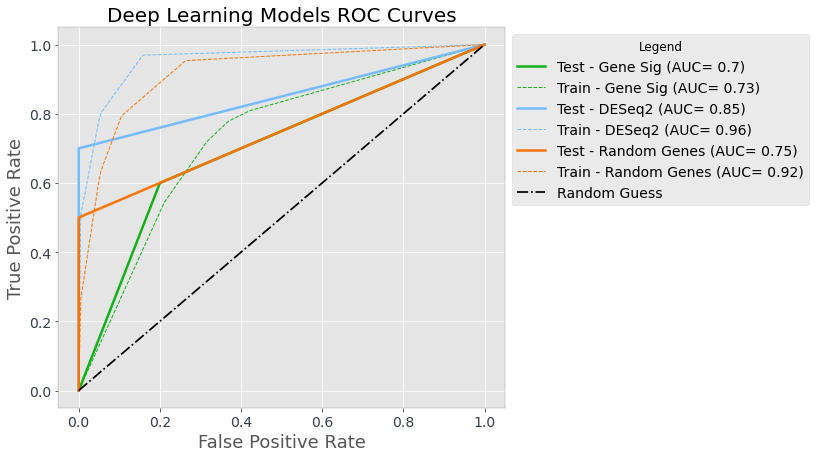

In [176]:
# Combine into single plot
fig =plt.figure(figsize=(8,7))

# Plot Gene Sig
test_label='Test - Gene Sig (AUC= '+str(round(test_auc_gs,2))+')'
plt.plot(fpr_gs, tpr_gs,'b', label=test_label,linewidth=2.5,color='xkcd:green')
train_label='Train - Gene Sig (AUC= '+str(round(sum(aucs_gs)/4,2))+')'
plt.plot(base_fpr, mean_tprs_gs, '--b',label=train_label,linewidth=1,color='xkcd:green')
#plt.fill_between(base_fpr, tprs_lower_gs, tprs_upper_gs, color='grey', alpha=0.3,label='STD 1')


# Plot DESEQ
test_label='Test - DESeq2 (AUC= '+str(round(test_auc_deseq,2))+')'
plt.plot(fpr_deseq, tpr_deseq,'r', label=test_label,linewidth=2.5,color='xkcd:sky blue')
train_label='Train - DESeq2 (AUC= '+str(round(sum(aucs_deseq)/4,2))+')'
plt.plot(base_fpr, mean_deseq, '--r',label=train_label,linewidth=1,color='xkcd:sky blue')
#plt.fill_between(base_fpr, tprs_lower_deseq, tprs_upper_deseq, color='grey', alpha=0.3,label='STD 1')

# Plot Random
test_label='Test - Random Genes (AUC= '+str(round(test_auc_rand,2))+')'
plt.plot(fpr_rand, tpr_rand,'g', label=test_label,linewidth=2.5,color='xkcd:orange')
train_label='Train - Random Genes (AUC= '+str(round(sum(aucs_rand)/4,2))+')'
plt.plot(base_fpr, mean_rand, '--g',label=train_label,linewidth=1,color='xkcd:orange')
#plt.fill_between(base_fpr, tprs_lower_rand, tprs_upper_rand, color='grey', alpha=0.3,label='STD 1')


# Labels and Plot settings
plt.plot([0, 1], [0, 1],'-.k',label='Random Guess',linewidth=1.75)
plt.ylabel('True Positive Rate',fontsize=18)
plt.xlabel('False Positive Rate',fontsize=18)
plt.title('Deep Learning Models ROC Curves',fontsize=20)
plt.legend(title='Legend', bbox_to_anchor=(1, 1), loc='upper left',fontsize=14)
plt.rcParams['legend.title_fontsize'] = 'large'
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Overall Combine Plots

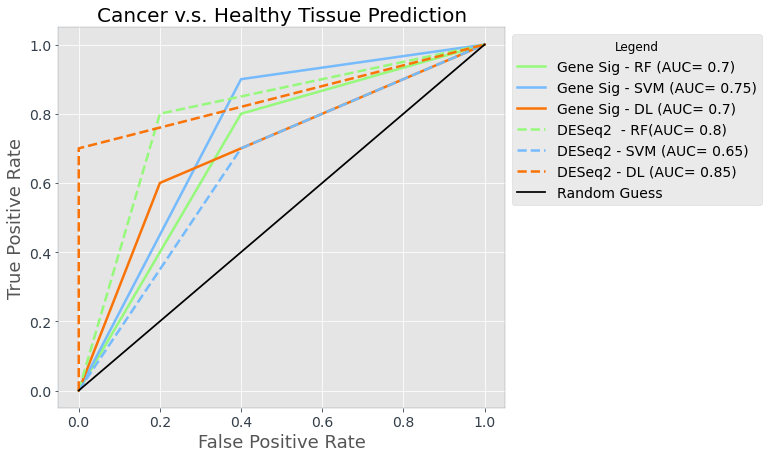

In [167]:
# Combine into single plot
fig =plt.figure(figsize=(8,7))

# Plot Gene Sig
# RF
test_label='Gene Sig - RF (AUC= '+str(round(auc_test_gs_rf,2))+')'
plt.plot(fpr_test_gs_rf, tpr_test_gs_rf,'xkcd:light green', label=test_label,linewidth=2.5,lineStyle='-' )
# svm
test_label='Gene Sig - SVM (AUC= '+str(round(test_auc_gs_svm,2))+')'
plt.plot(fpr_test_gs_svm, tpr_test_gs_svm,'xkcd:sky blue', label=test_label,linewidth=2.5,lineStyle='-')
# DL
test_label='Gene Sig - DL (AUC= '+str(round(test_auc_gs,2))+')'
plt.plot(fpr_gs, tpr_gs,'xkcd:orange', label=test_label,linewidth=2.5,lineStyle='-')


# Plot DESEQ
#RF
test_label='DESeq2  - RF(AUC= '+str(round(auc_test_seq_rf,2))+')'
plt.plot(fpr_test_seq_rf, tpr_test_seq_rf,'xkcd:light green', label=test_label,linewidth=2.5,lineStyle='--' )
# svm
test_label='DESeq2 - SVM (AUC= '+str(round(test_auc_seq_svm,2))+')'
plt.plot(fpr_test_seq_svm, tpr_test_seq_svm,'xkcd:sky blue', label=test_label,linewidth=2.5,lineStyle='--' )
#Dl
test_label='DESeq2 - DL (AUC= '+str(round(test_auc_deseq,2))+')'
plt.plot(fpr_deseq, tpr_deseq,'xkcd:orange', label=test_label,linewidth=2.5,lineStyle='--' )


# Labels and Plot settings
plt.plot([0, 1], [0, 1],'k',label='Random Guess',linewidth=1.75)
plt.ylabel('True Positive Rate',fontsize=18)
plt.xlabel('False Positive Rate',fontsize=18)
plt.title('Cancer v.s. Healthy Tissue Prediction',fontsize=20)
plt.legend(title='Legend', bbox_to_anchor=(1, 1), loc='upper left',fontsize=14)
plt.rcParams['legend.title_fontsize'] = 'large'
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

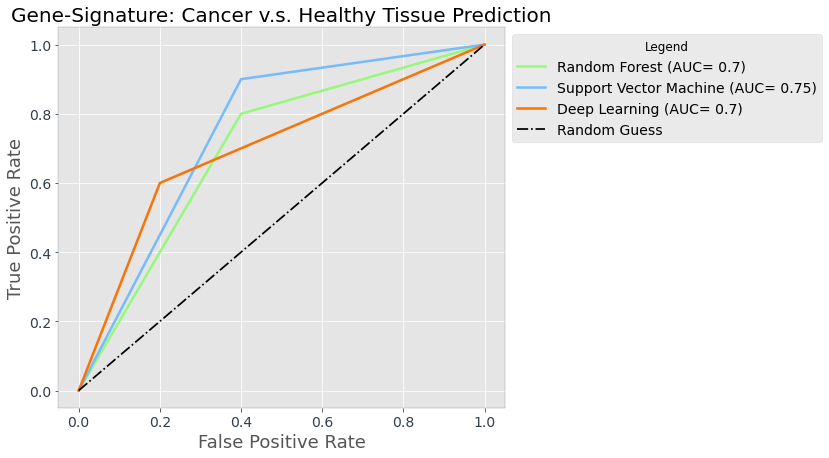

In [134]:
# Combine into single plot
fig =plt.figure(figsize=(8,7))

# Plot Gene Sig
# RF
test_label='Random Forest (AUC= '+str(round(auc_test_gs_rf,2))+')'
plt.plot(fpr_test_gs_rf, tpr_test_gs_rf,'xkcd:light green', label=test_label,linewidth=2.5,lineStyle='-' )
# svm
test_label='Support Vector Machine (AUC= '+str(round(test_auc_gs_svm,2))+')'
plt.plot(fpr_test_gs_svm, tpr_test_gs_svm,'xkcd:sky blue', label=test_label,linewidth=2.5,lineStyle='-')
# DL
test_label='Deep Learning (AUC= '+str(round(test_auc_gs,2))+')'
plt.plot(fpr_gs, tpr_gs,'xkcd:orange', label=test_label,linewidth=2.5,lineStyle='-')

# Labels and Plot settings
plt.plot([0, 1], [0, 1],'-.k',label='Random Guess',linewidth=1.75)
plt.ylabel('True Positive Rate',fontsize=18)
plt.xlabel('False Positive Rate',fontsize=18)
plt.title('Gene-Signature: Cancer v.s. Healthy Tissue Prediction',fontsize=20)
plt.legend(title='Legend', bbox_to_anchor=(1, 1), loc='upper left',fontsize=14)
plt.rcParams['legend.title_fontsize'] = 'large'
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

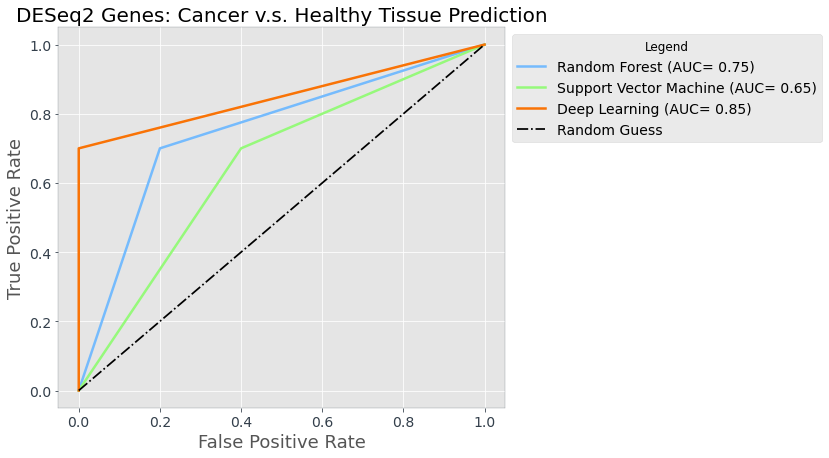

In [135]:
#DESeq2
# Plot DESEQ
# Combine into single plot
fig =plt.figure(figsize=(8,7))

#RF
test_label='Random Forest (AUC= '+str(round(auc_test_seq_rf,2))+')'
plt.plot(fpr_test_seq_rf, tpr_test_seq_rf,'xkcd:sky blue', label=test_label,linewidth=2.5,lineStyle='-' )
# svm
test_label='Support Vector Machine (AUC= '+str(round(test_auc_seq_svm,2))+')'
plt.plot(fpr_test_seq_svm, tpr_test_seq_svm,'xkcd:light green', label=test_label,linewidth=2.5,lineStyle='-' )
#Dl
test_label='Deep Learning (AUC= '+str(round(test_auc_deseq,2))+')'
plt.plot(fpr_deseq, tpr_deseq,'xkcd:orange', label=test_label,linewidth=2.5,lineStyle='-' )

# Labels and Plot settings
plt.plot([0, 1], [0, 1],'-.k',label='Random Guess',linewidth=1.75)
plt.ylabel('True Positive Rate',fontsize=18)
plt.xlabel('False Positive Rate',fontsize=18)
plt.title('DESeq2 Genes: Cancer v.s. Healthy Tissue Prediction',fontsize=20)
plt.legend(title='Legend', bbox_to_anchor=(1, 1), loc='upper left',fontsize=14)
plt.rcParams['legend.title_fontsize'] = 'large'
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [170]:
# Create Data Frame for results
svM=pd.Series([test_auc_gs_svm,test_auc_seq_svm,test_auc_rand_svm], name='Support Vector Machine')
rf=pd.Series([auc_test_gs_rf,auc_test_seq_rf,auc_test_rand_rf], name='Random Forest')
dl=pd.Series([test_auc_gs,test_auc_deseq,test_auc_rand], name='Deep Learning')
ind=pd.Series(['Gene-Signature','DESeq2','Random'], name='index')

results=pd.concat([svM,rf,dl,ind], axis=1)
results.set_index(['index'],inplace=True)
results.head()

,Support Vector Machine,Random Forest,Deep Learning
index,,,
Gene-Signature,0.75,0.70,0.70
DESeq2,0.65,0.80,0.85
Random,0.60,0.55,0.75


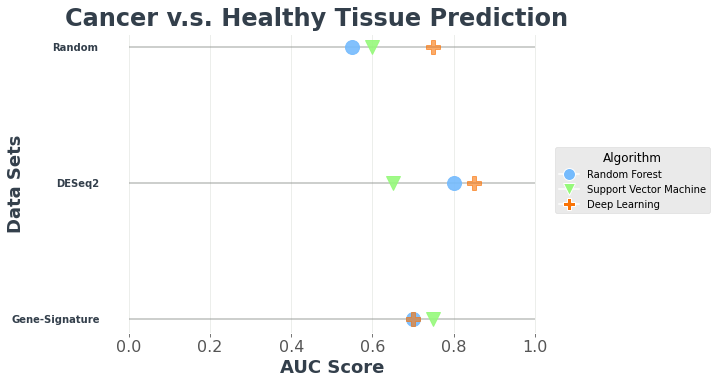

In [171]:
# plot! 
plt.style.available
plt.style.use('ggplot')
# we first need a numeric placeholder for the y axis
my_range=list(range(1,4))
fig, ax = plt.subplots(figsize=(8,5.5))

# Grey line
plt.hlines(y=my_range, xmin=0, xmax=1, color='xkcd:grey', alpha=0.45, linewidth=2)

# MArkers
plt.plot(results['Random Forest'], my_range, "o", markersize=14, color='xkcd:sky blue', alpha=0.9)
plt.plot(results['Deep Learning'], my_range, "P", markersize=14, color='xkcd:orange', alpha=0.6)
plt.plot(results['Support Vector Machine'], my_range, "v", markersize=14, color='xkcd:light green', alpha=0.9)

# set labels
ax.set_xlabel('AUC Score', fontsize=18, fontweight='black', color = '#333F4B')
plt.text(-0.30, 2,'Data Sets', ha ='left', va ='center', color = '#333F4B',weight='bold',rotation=90, fontsize=18)

# set axis
ax.tick_params(axis='y', which='major', labelsize=14)
ax.tick_params(axis='x', which='major', labelsize=16)
plt.yticks(my_range, results.index)

# add ttile
fig.text(0.05, 0.9, 'Cancer v.s. Healthy Tissue Prediction', fontsize=24, fontweight='black', color = '#333F4B')


ax.get_yaxis().set_visible(False)
labs=results.index.to_list()
plt.text(-0.29, 1,labs[0], ha ='left', va ='center', color = '#333F4B',weight='bold')
plt.text(-.18, 2,labs[1], ha ='left', va ='center', color = '#333F4B',weight='bold')
plt.text(-0.19, 3,labs[2], ha ='left', va ='center', color = '#333F4B',weight='bold')



# styling
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.2
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
ax.set_facecolor('xkcd:white')


# Legend
legend_elements = [ Line2D([0], [0], marker='o', color='w', label='Random Forest', markerfacecolor='xkcd:sky blue', markersize=12),\
                   Line2D([0], [0], marker='v', color='w', label='Support Vector Machine', markerfacecolor='xkcd:light green', markersize=12),\
                   Line2D([0], [0], marker='P', color='w', label='Deep Learning', markerfacecolor='xkcd:orange', markersize=12) ]
plt.legend(title='Algorithm',handles=legend_elements,loc=(1,0.4))
ax.grid(True,color='xkcd:light grey', alpha=0.6)
plt.show()

# Exploring Further - Gene Discivery
In this section, I create a new model using a larger random gene set! The motivation behind this is to find new genes (outside of the gene signature that can be used as possible markers). 

Using the entire gene set is not ideal because:
1. It is way too large with not enough samples ~17,000 genes for 55 samples. Makes it hard to train computationally, and has too much variance
2. Using the smaller gene siganture from litature had strong potential but is limited by its small size.

# Train Model with random genes

### Deep Learning 

In [181]:
num_genes=100
genes=df.columns.to_list()
# generate random genes
random.seed()
n = random.sample(range(0, len(genes)), num_genes)
rand_genes=[genes[i] for i in n]
# subset dataset
rand_df=df[rand_genes].copy()

# SPlit data
# Split Into Training and Test Data
x_train, x_test, y_train, y_test = train_test_split(rand_df, target_binary, test_size=15,shuffle=True, random_state=12)
kf = KFold(n_splits = 4)                      
skf = StratifiedKFold(n_splits = 4, random_state = 12, shuffle = True) # Generates indicies


In [182]:
# Creating Model

# define baseline model
# create model
def baseline_model():
   # create model
    model = Sequential()
    model.add(Dense(64, input_dim=100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='Nadam', metrics=['accuracy'])
    return model


Fold Number: 1

Fold Number: 2

Fold Number: 3

Fold Number: 4

Test Data:
[[3 2]
 [4 6]]
Accuracy: 0.6
AUC: 0.6000

Overall Acc is:
0.7555


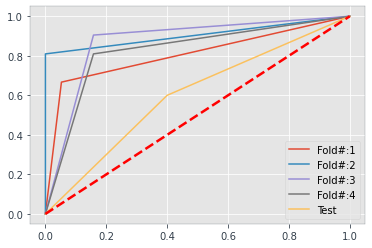

In [183]:
# Using K-Fold

estimator = KerasClassifier(build_fn=baseline_model, epochs=125, batch_size=2, verbose=0)
c=1
acc_tot=0
for train_index, test_index in skf.split(x_train, y_train):
    print('\nFold Number: %d'%(c))
    X=x_train.iloc[train_index]
    Y=y_train.iloc[train_index]
    estimator.fit(X, Y)
    results=estimator.predict(x_train)
    
    cm=confusion_matrix(y_train, results)
    # ROC 
    fpr_kera, tpr_kera, thresholds_rf = roc_curve(y_train, results)
    auc_k = auc(fpr_kera, tpr_kera)
    lab='Fold#:'+str(c)
    plt.plot(fpr_kera, tpr_kera, label=lab)
    acc=round((cm[1,1]+cm[0,0])/45,4)
    acc_tot=acc_tot+acc
    c+=1


# Test Set
print('\nTest Data:')

# run it foward
results=estimator.predict(x_test)
cm=confusion_matrix(y_test, results)
# ROC 
fpr_kera, tpr_kera, thresholds_rf = roc_curve(y_test, results)
auc_k = auc(fpr_kera, tpr_kera)
lab='Test'
plt.plot(fpr_kera, tpr_kera, label=lab)

# show results
print(cm)
print('Accuracy:',round((cm[1,1]+cm[0,0])/15,4))
print('AUC: %.4f'%(auc_k))
print('\nOverall Acc is:\n%.4f'%(acc_tot/4))

# plot 
plt.legend()
plt.plot([0, 1], [0, 1],'r--',linewidth=2.5)

In [251]:
rand_genes

['PGAM2',
 'NAB1',
 'PRRC2B',
 'USP32P1',
 'PASK',
 'TM4SF18',
 'DDIT4',
 'EPHA6',
 'NAA40',
 'PPP3CC',
 'TTC33',
 'DCTN2',
 'PRDM13',
 'RNU6-901P',
 'MFSD2B',
 'KDM5A',
 'TSPY7P',
 'RNU1-62P',
 'CACNB2',
 'GNB1',
 'VPS8',
 'CLDN20',
 'ARMC2',
 'POLR3A',
 'ACOXL',
 'TRAJ42',
 'SFRP5',
 'CCDC83',
 'TUBE1',
 'LOXL3',
 'PRPS1',
 'INTS4P1',
 'RNA5SP204',
 'TFF3',
 'LGI4',
 'ALDH1L1',
 'TMEM74',
 'PNPLA4',
 'RNA5SP91',
 'DEFB103B_0',
 'RN7SKP95',
 'RNF128',
 'MYCBP2',
 'NHLRC2',
 'FAM53B',
 'RNU6-932P',
 'P4HA2',
 'RNA5SP292',
 'SVBP',
 'NFATC4_458',
 'ISYNA1',
 'ZNF506',
 'HNRNPA0',
 'MYO1H',
 'ACAP2',
 'RNU6-2',
 'GATM',
 'SP8',
 'SRY',
 'SI',
 'RTP2',
 'ZNF527',
 'RBM45',
 'AMIGO2',
 'SAA3P',
 'ATL1',
 'UBQLN2',
 'KCNJ2',
 'LINC01555',
 'CACHD1',
 'ZFAND1',
 'RGPD2',
 'CIPC',
 'IL13RA2',
 'PTDSS1',
 'SLC25A51',
 'CCDC190',
 'CCDC197',
 'STARD7',
 'RNU6-306P',
 'CBX1',
 'TCF19_442',
 'PABPC4',
 'F7',
 'POU6F2',
 'GRPEL2',
 'PAFAH1B3',
 'FTHL17',
 'GNE',
 'IRAG1',
 'SAMHD1',
 'SIX3',
 'LIN

### SVM

In [250]:
num_genes=100
genes=df.columns.to_list()
# generate random genes
random.seed()
n = random.sample(range(0, len(genes)), num_genes)
rand_genes=[genes[i] for i in n]
# subset dataset
rand_df=df[rand_genes].copy()

# SPlit data
# Split Into Training and Test Data
x_train, x_test, y_train, y_test = train_test_split(rand_df, target_binary, test_size=15,shuffle=True, random_state=12)
kf = KFold(n_splits = 4)                      
skf = StratifiedKFold(n_splits = 4, random_state = 12, shuffle = True) # Generates indicies

#GET PCA of Gene Sig
pca = PCA(n_components=2)
Xreduced = pca.fit_transform(rand_df)
#pca_cov = pd.DataFrame({"Gene": genes,"PC1_Covariance":abs(pca.components_[0]),"PC2_Covariance":abs(pca.components_[1]) })

# Split Data
x_train, x_test, y_train, y_test = train_test_split(Xreduced, target_binary, test_size=15,shuffle=True, random_state=12)
clf_rand = svm.NuSVC(gamma='auto')
# Fit model
clf_rand.fit(x_train, y_train)

# Get results of TRAIN data
results = clf_rand.predict(x_train)

# Generate ROC Curve
fpr_train_rand_svm, tpr_train_rand_svm, thresholds_rf = roc_curve(y_train, results)

# Calculate AUC (Area under the ROC Curve )
train_auc_rand_svm = round(auc(fpr_train_rand_svm, tpr_train_rand_svm),2)
print(train_auc_rand_svm)
# run it foward - to predict using TEST
results=clf_rand.predict(x_test)

# Generate ROC Curve 
fpr_test_rand_svm, tpr_test_rand_svm, thresholds_rf = roc_curve(y_test, results)

# Calculate AUC (Area under the ROC Curve )
test_auc_rand_svm = round(auc(fpr_test_rand_svm, tpr_test_rand_svm),2)

# show results FOR TEST + Overall Train
print(' Test AUC: %.4f'%(test_auc_rand_svm))

0.9
 Test AUC: 0.7000


### RF

In [196]:
num_genes=100
genes=df.columns.to_list()
# generate random genes
random.seed()
n = random.sample(range(0, len(genes)), num_genes)
rand_genes=[genes[i] for i in n]
# subset dataset
rand_df=df[rand_genes].copy()

# SPlit data
# Split Into Training and Test Data
x_train, x_test, y_train, y_test = train_test_split(rand_df, target_binary, test_size=15,shuffle=True, random_state=12)
kf = KFold(n_splits = 4)                      
skf = StratifiedKFold(n_splits = 4, random_state = 12, shuffle = True) # Generates indicies
# Initialize random forest mode
rfc_rand = RandomForestClassifier()
rfc_rand.fit(x_train, y_train)

# Get results of TRAIN data
results = rfc_rand.predict(x_train)

# Generate ROC Curve
fpr_train_rand_rf, tpr_train_rand_rf, thresholds_rf = roc_curve(y_train, results)

# Calculate AUC (Area under the ROC Curve )
auc_train_rand_rf = auc(fpr_train_rand_rf, tpr_train_rand_rf)
print(auc_train_rand_rf)

results=rfc_rand.predict(x_test)

# Generate ROC Curve 
fpr_test_rand_rf, tpr_test_rand_rf, thresholds_rf = roc_curve(y_test, results)

# Calculate AUC (Area under the ROC Curve )
auc_test_rand_rf = auc(fpr_test_rand_rf, tpr_test_rand_rf)

# show results FOR TEST + Overall Train
print('AUC test: %.4f'%(auc_test_rand_rf))




1.0
AUC test: 0.8500


In [198]:
5# acc=0.85
discoverd_genes_rf=['KMT5A',
 'ABCB6',
 'UPP1',
 'RABL2A',
 'SLC13A5',
 'OBP2A',
 'PIGO',
 'TRAJ18',
 'EXTL1',
 'CD22',
 'RNU6-748P',
 'RNA5SP491',
 'DGAT1_853',
 'CLIC6',
 'H3C14',
 'RN7SKP186',
 'BCL9L',
 'MRPS12_175',
 'GABRA4',
 'CDC14B',
 'STRA8',
 'SNORA22B',
 'NFATC3',
 'MLH3',
 'BCL2L13',
 'LIN52',
 'TRIM62',
 'MYPOP',
 'TRMT10C',
 'HSPBAP1',
 'RNU6-281P',
 'NMNAT2',
 'PUM2',
 'SGSM3',
 'SRGAP1',
 'BMP6',
 'PNMA8B',
 'C15orf54',
 'RPL32',
 'MPRIP',
 'CEP162',
 'C1QTNF2',
 'CXCL17',
 'THNSL1',
 'SNRNP25',
 'PTTG1',
 'RNA5SP509',
 'DPPA4',
 'ALOX15P2',
 'DOCK8-AS1',
 'MORF4L2',
 'LINC00467',
 'RNU6-354P',
 'RNU6-1075P',
 'CCT8',
 'VIRMA',
 'PRNT',
 'SLC14A1',
 'COL4A2',
 'NAA11',
 'ATP6V1G3_0',
 'C2orf83',
 'AP4S1',
 'RNU6-637P',
 'A1BG',
 'CCDC60',
 'HTR7',
 'TMPRSS3',
 'PSMD1',
 'VEGFC',
 'BBOF1',
 'CBX3',
 'RNU6-131P',
 'ANXA7',
 'CGB5',
 'DDX41',
 'ME2',
 'SGMS1',
 'IL12RB2',
 'KRTAP9-9',
 'GZMK',
 'NTN5',
 'IGHD5-24',
 'COPS8',
 'RFK',
 'HDX',
 'RFESD',
 'SCN9A',
 'ABHD16A_312',
 'SLC38A3',
 'BMPR1B',
 'C3orf33',
 'HTRA3',
 'CAPN11',
 'FEZF2',
 'GPR149',
 'PYROXD1',
 'PHPT1',
 'TMEM223',
 'FUT11']

In [187]:
#0.75
discivered_genes_dl=['PHETA2',
 'RN7SKP291',
 'PRKAG1',
 'NAV2',
 'ZNF83',
 'FBF1',
 'HERC4',
 'SEMA4F',
 'LPGAT1',
 'ECHDC1',
 'ATP13A5',
 'LRRC43',
 'GLUL',
 'SMPD5',
 'MIR567',
 'CFAP36',
 'PGLYRP1',
 'RIMBP3C',
 'ATP6V1C2',
 'ARHGEF1',
 'PLA2G10_64',
 'IQGAP3',
 'ZNF582',
 'DDX39B_4758',
 'KLHL18',
 'SCMH1',
 'TRAV8-7',
 'HMCN1',
 'RNU6-597P',
 'LIN28B-AS1',
 'SLCO4A1',
 'RTN4RL2',
 'PROKR2',
 'SH3BGRL3',
 'IER3_4913',
 'H2BC18',
 'FECH',
 'PPIAP7',
 'SYNM',
 'MIS18A',
 'MDN1',
 'CXorf38',
 'GPR119',
 'SMN1_96',
 'POMT2',
 'POLR3C',
 'KNOP1',
 'POP7',
 'PPP1R3F',
 'SNX2',
 'GALNT9_0',
 'CETN1',
 'SPINK6',
 'ATAD2',
 'MIR606',
 'RPL31P11',
 'PIH1D1',
 'GIMAP6',
 'DCTD',
 'YRDC',
 'EIF4E3',
 'STRBP',
 'ZNF37CP',
 'RNU6-279P',
 'SIRT3',
 'RPL12P16',
 'MIR588',
 'PLAAT1',
 'SNORD67',
 'CBWD4P',
 'HDHD5',
 'ARMH3',
 'MLLT11',
 'ISLR2',
 'R3HCC1',
 'ARHGAP9',
 'FOXN4',
 'IGSF9',
 'RASGRP1',
 'NCOA5',
 'TIMM44',
 'PRAMEF8_0',
 'FDFT1_4025',
 'BIVM',
 'IL4I1',
 'GAPDHP44',
 'KLF9',
 'EEF1AKMT2',
 'ENTR1P2',
 'BMF',
 'DMRTB1',
 'IGHV1-58',
 'ERLEC1',
 'TTLL1',
 'SNORD116-29',
 'ZNF135',
 'APOBEC3F',
 'NMNAT2',
 'TMEM209',
 'SEC23IP']

In [252]:
0.7
discoverd_genes_svm=['PGAM2',
 'NAB1',
 'PRRC2B',
 'USP32P1',
 'PASK',
 'TM4SF18',
 'DDIT4',
 'EPHA6',
 'NAA40',
 'PPP3CC',
 'TTC33',
 'DCTN2',
 'PRDM13',
 'RNU6-901P',
 'MFSD2B',
 'KDM5A',
 'TSPY7P',
 'RNU1-62P',
 'CACNB2',
 'GNB1',
 'VPS8',
 'CLDN20',
 'ARMC2',
 'POLR3A',
 'ACOXL',
 'TRAJ42',
 'SFRP5',
 'CCDC83',
 'TUBE1',
 'LOXL3',
 'PRPS1',
 'INTS4P1',
 'RNA5SP204',
 'TFF3',
 'LGI4',
 'ALDH1L1',
 'TMEM74',
 'PNPLA4',
 'RNA5SP91',
 'DEFB103B_0',
 'RN7SKP95',
 'RNF128',
 'MYCBP2',
 'NHLRC2',
 'FAM53B',
 'RNU6-932P',
 'P4HA2',
 'RNA5SP292',
 'SVBP',
 'NFATC4_458',
 'ISYNA1',
 'ZNF506',
 'HNRNPA0',
 'MYO1H',
 'ACAP2',
 'RNU6-2',
 'GATM',
 'SP8',
 'SRY',
 'SI',
 'RTP2',
 'ZNF527',
 'RBM45',
 'AMIGO2',
 'SAA3P',
 'ATL1',
 'UBQLN2',
 'KCNJ2',
 'LINC01555',
 'CACHD1',
 'ZFAND1',
 'RGPD2',
 'CIPC',
 'IL13RA2',
 'PTDSS1',
 'SLC25A51',
 'CCDC190',
 'CCDC197',
 'STARD7',
 'RNU6-306P',
 'CBX1',
 'TCF19_442',
 'PABPC4',
 'F7',
 'POU6F2',
 'GRPEL2',
 'PAFAH1B3',
 'FTHL17',
 'GNE',
 'IRAG1',
 'SAMHD1',
 'SIX3',
 'LINC00632',
 'ZNF484',
 'STBD1',
 'PLEKHG3',
 'IER5L',
 'ATP11AUN',
 'TMCO2',
 'HNRNPLL']

<AxesSubplot:>

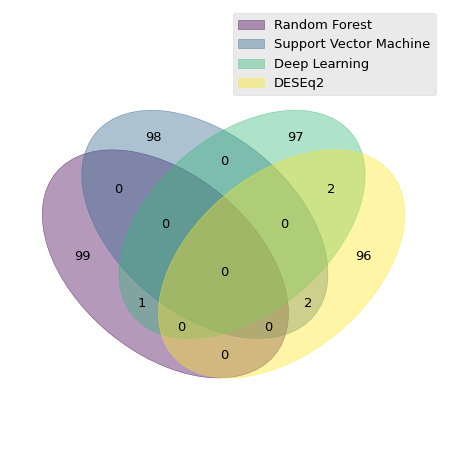

In [253]:
from venn import venn
%matplotlib inline
seq=pd.read_csv('top_genes.csv') # load
seq=seq.head(100)
seq=seq['Unnamed: 0'].to_list()

musicians = {
    "Random Forest":set(discoverd_genes_rf),
    "Support Vector Machine": set(discoverd_genes_svm),
    "Deep Learning": set(discivered_genes_dl),
    "DESEq2":set(seq)
}
venn(musicians)

In [189]:
set(seq).intersection(set(discivered_genes_dl))

{'IGHV1-58', 'SNORD67'}

In [70]:
set(seq).intersection(set(discoverd_genes_svm))

{'MT-TV'}

In [71]:
set(seq).intersection(set(discoverd_genes_rf))

set()